In [149]:
import numpy as np
import pandas as pd
from vnstock import Vnstock
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import gaussian_kde
from scipy.stats import beta, dirichlet, norm,invwishart, invgamma, beta
from scipy.special import gammaln, gamma
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import time
from datetime import datetime
from scipy import stats


# 0. OVERVIEW

In [150]:
# Load Stock Data
stock = Vnstock().stock()
ASSETS = ["HPG", "VCB", "CTG", "MSN", "MWG"]

#choose historical data of 9 stocks in 5-year period (2020-2025)
start_date = "2020-01-01"
end_date = "2025-01-01"

NUM_PORTFOLIOS = 100_000

data= pd.DataFrame()
for ticker in ASSETS:
    stock = Vnstock().stock(symbol= ticker, source='VCI')
    data[ticker] = stock.quote.history(start=start_date, end=end_date)["close"]
data = data.set_index(stock.quote.history(start=start_date, end=end_date)["time"])

2025-07-07 15:53:30 - vnstock.common.vnstock - INFO - Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M


2025-07-07 15:53:30 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.


In [151]:
#view historical price of the portfolio
data.head()

,HPG,VCB,CTG,MSN,MWG
time,,,,,
2020-01-02,8.28,39.49,14.35,46.12,37.43
2020-01-03,8.33,39.10,14.21,46.53,36.89
2020-01-06,8.28,38.06,14.25,45.80,36.70
2020-01-07,8.17,38.19,14.48,45.96,36.99
2020-01-08,8.09,37.84,14.45,45.32,36.09


In [152]:
#calculate daily log-return
daily_log_returns = np.log(data / data.shift(1)).dropna()
mean_returns = daily_log_returns.mean()
print(mean_returns)

HPG    0.000790
VCB    0.000348
CTG    0.000775
MSN    0.000334
MWG    0.000391
dtype: float64


In [153]:
#calculate covariance 
cov_matrix = daily_log_returns.cov()
print(cov_matrix)

          HPG       VCB       CTG       MSN       MWG
HPG  0.000495  0.000144  0.000267  0.000212  0.000254
VCB  0.000144  0.000267  0.000187  0.000127  0.000137
CTG  0.000267  0.000187  0.000492  0.000193  0.000247
MSN  0.000212  0.000127  0.000193  0.000508  0.000241
MWG  0.000254  0.000137  0.000247  0.000241  0.000521


In [154]:
RISK_FREE_RATE = 0.03

## Metropolis-Hasting Algorithm

## Create The Model

In [155]:
# Observed data: daily log returns
observed_daily_returns = daily_log_returns.values  # Shape: (n_days, n_assets)
n_observations, n_assets = observed_daily_returns.shape

n_assets = len(ASSETS)
n_observations = observed_daily_returns.shape[0]

with pm.Model() as bayesian_model:
    # Priors for expected returns (Multivariate Normal)
    mu_0 = daily_log_returns.mean().values * 252
    sample_cov_annual = daily_log_returns.cov().values * 252
    kappa = 5
    Sigma_0 = sample_cov_annual / kappa

    annual_returns = pm.MvNormal(
        'annual_returns',
        mu=mu_0,
        cov=Sigma_0,
        shape=n_assets
    )

    # Prior for covariance matrix
    annual_cov_chol, annual_cov_corr, annual_cov_stds = pm.LKJCholeskyCov(
        'annual_cov',
        n=n_assets,
        eta=1.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True
    )
    annual_cov = pm.Deterministic(
        'annual_covariance_matrix',
        pt.dot(annual_cov_chol, annual_cov_chol.T)
    )

    # Convert to daily
    daily_returns = pm.Deterministic('daily_returns', annual_returns / 252.0)
    daily_cov = pm.Deterministic('daily_cov', annual_cov / 252.0)

    # Likelihood
    likelihood = pm.MvNormal(
        'observed_returns_likelihood',
        mu=daily_returns,
        cov=daily_cov,
        observed=observed_daily_returns
    )


## Run MCMC Sampling

In [156]:
with bayesian_model:
    trace = pm.sample(
        draws=20000,       
        tune=5000,        
        chains=2,
        step=pm.Metropolis(),
        cores=1,
        return_inferencedata=True,
        random_seed=42
    )


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [annual_returns]
>Metropolis: [annual_cov]


install "ipywidgets" for Jupyter support

overflow encountered in exp

Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 191 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Analyze Result

In [157]:
az.summary(trace, var_names=["annual_returns", "annual_cov"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
annual_returns[0],0.203,0.113,-0.009,0.411,0.002,0.001,2562.0,5320.0,1.0
annual_returns[1],0.089,0.083,-0.066,0.244,0.001,0.001,3150.0,5352.0,1.0
annual_returns[2],0.198,0.112,-0.015,0.405,0.002,0.001,2393.0,4149.0,1.0
annual_returns[3],0.086,0.115,-0.126,0.305,0.002,0.001,3021.0,5760.0,1.0
annual_returns[4],0.100,0.116,-0.119,0.317,0.002,0.001,2674.0,5290.0,1.0
annual_cov[0],0.353,0.007,0.340,0.367,0.000,0.000,3523.0,5571.0,1.0
annual_cov[1],0.102,0.007,0.089,0.115,0.000,0.000,3933.0,5415.0,1.0
annual_cov[2],0.239,0.005,0.230,0.247,0.000,0.000,6663.0,8153.0,1.0
annual_cov[3],0.190,0.009,0.172,0.206,0.000,0.000,3114.0,4748.0,1.0
annual_cov[4],0.116,0.008,0.100,0.131,0.000,0.000,5601.0,7135.0,1.0


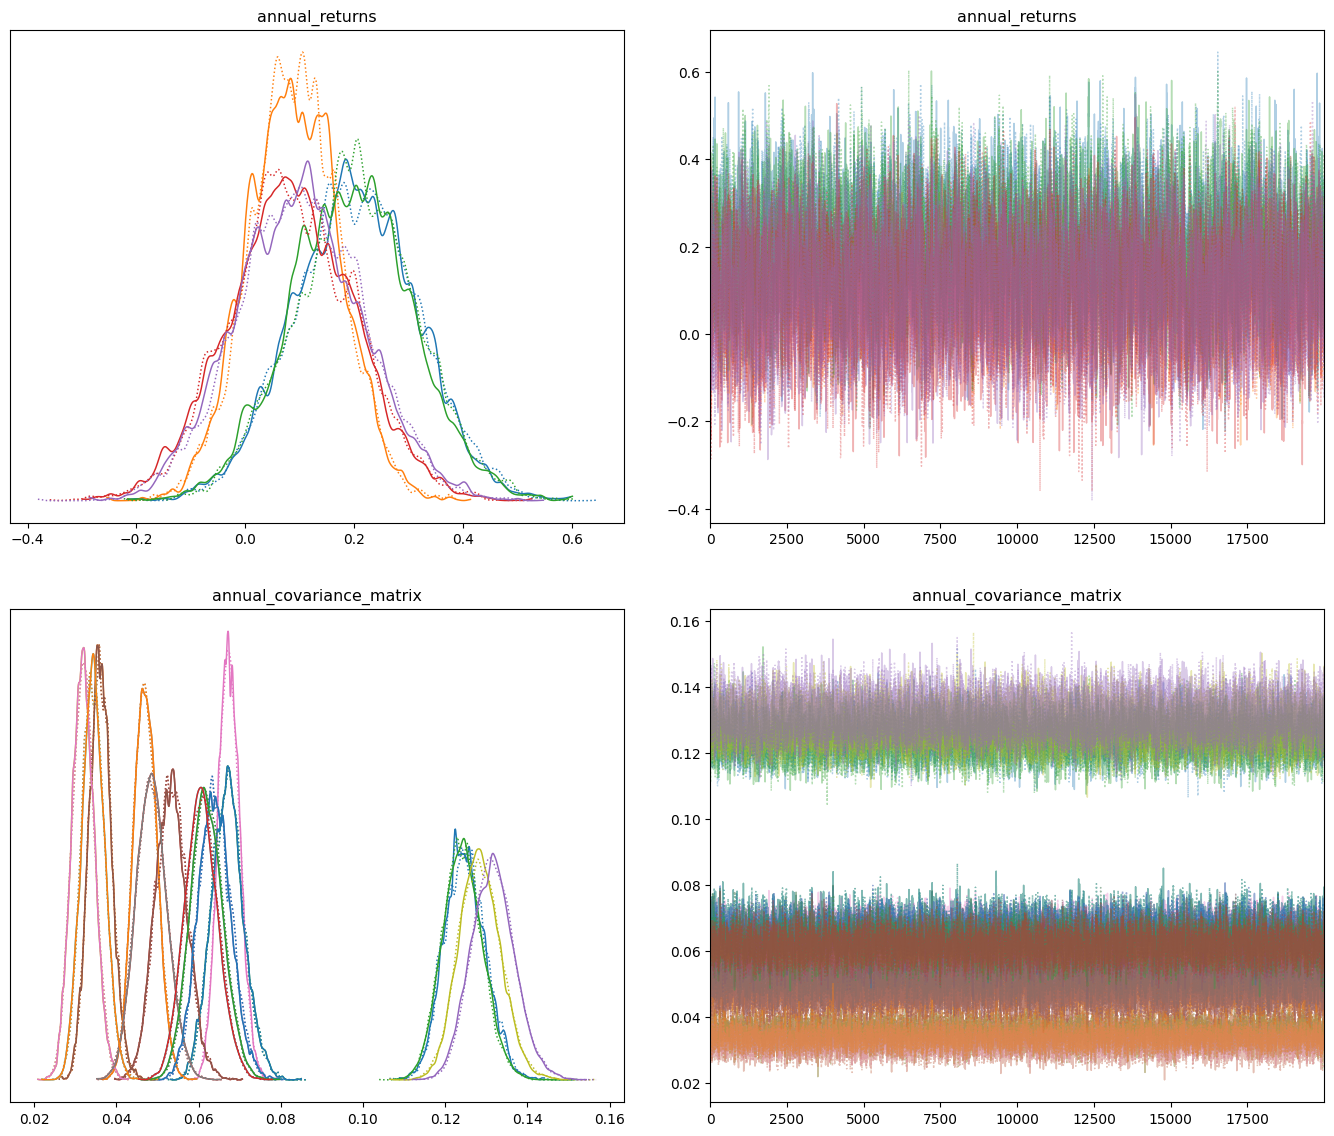

In [158]:
axes = az.plot_trace(trace, var_names=["annual_returns", "annual_covariance_matrix"], figsize=(14, 12))
plt.tight_layout(pad=3.0)  # Tăng khoảng cách giữa các plot
plt.show()

In [ ]:
mu_samples = trace.posterior['annual_returns'].values
cov_samples = trace.posterior['annual_covariance_matrix'].values

In [160]:
n_chains, n_draws, n_assets = mu_samples.shape 
mu_samples_flat = mu_samples.reshape(-1, n_assets)       # shape (samples, assets)
cov_samples_flat = cov_samples.reshape(-1, n_assets, n_assets)
n_samples = mu_samples_flat.shape[0]

In [161]:
# Maximize Sharpe Ratio
def negative_sharpe(weights, mean_returns, cov_matrix):
    ret = np.sum(weights * mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(ret - RISK_FREE_RATE) / vol

In [162]:
# Compute makowitz problem with all samples of mu and cov
results = {
    "weights": [],
    "return": [],
    "volatility": [],
    "sharpe": [],
}

bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
initial_guess = np.repeat(1/n_assets, n_assets)

for i in range(n_samples):
    mu_i = mu_samples_flat[i]
    cov_i = cov_samples_flat[i]
    
    res = minimize(
        negative_sharpe,
        initial_guess,
        args=(mu_i, cov_i),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
    )
    
    if res.success:
        w_opt = res.x
        ret_opt = np.sum(w_opt * mu_i)
        vol_opt = np.sqrt(np.dot(w_opt.T, np.dot(cov_i, w_opt)))
        sharpe_opt = (ret_opt - RISK_FREE_RATE) / vol_opt
        
        results["weights"].append(w_opt)
        results["return"].append(ret_opt)
        results["volatility"].append(vol_opt)
        results["sharpe"].append(sharpe_opt)


In [163]:
#Convert to arrays
returns_array  = np.array(results["return"])
vols_array     = np.array(results["volatility"])
sharpes_array  = np.array(results["sharpe"])
weights_array  = np.array(results["weights"])   # shape (n_samples, n_assets)

In [164]:
# Compute mean 
mean_return = returns_array.mean()
mean_vol    = vols_array.mean()
mean_sharpe = sharpes_array.mean()
mean_weights = weights_array.mean(axis=0)   # shape (n_assets,)

In [165]:
#Show results
print("=== Mean Optimized Portfolio across MCMC Samples ===")
print(f"Expected Return: {mean_return*100:.2f}%")
print(f"Volatility:      {mean_vol*100:.2f}%")
print(f"Sharpe Ratio:    {mean_sharpe:.3f}")
print("\nMean Weights:")
for asset, w in zip(ASSETS, mean_weights):
    print(f"  {asset}: {w:.4f} ({w*100:.1f}%)")

=== Mean Optimized Portfolio across MCMC Samples ===
Expected Return: 23.51%
Volatility:      30.46%
Sharpe Ratio:    0.681

Mean Weights:
  HPG: 0.3678 (36.8%)
  VCB: 0.1361 (13.6%)
  CTG: 0.3405 (34.0%)
  MSN: 0.0836 (8.4%)
  MWG: 0.0720 (7.2%)


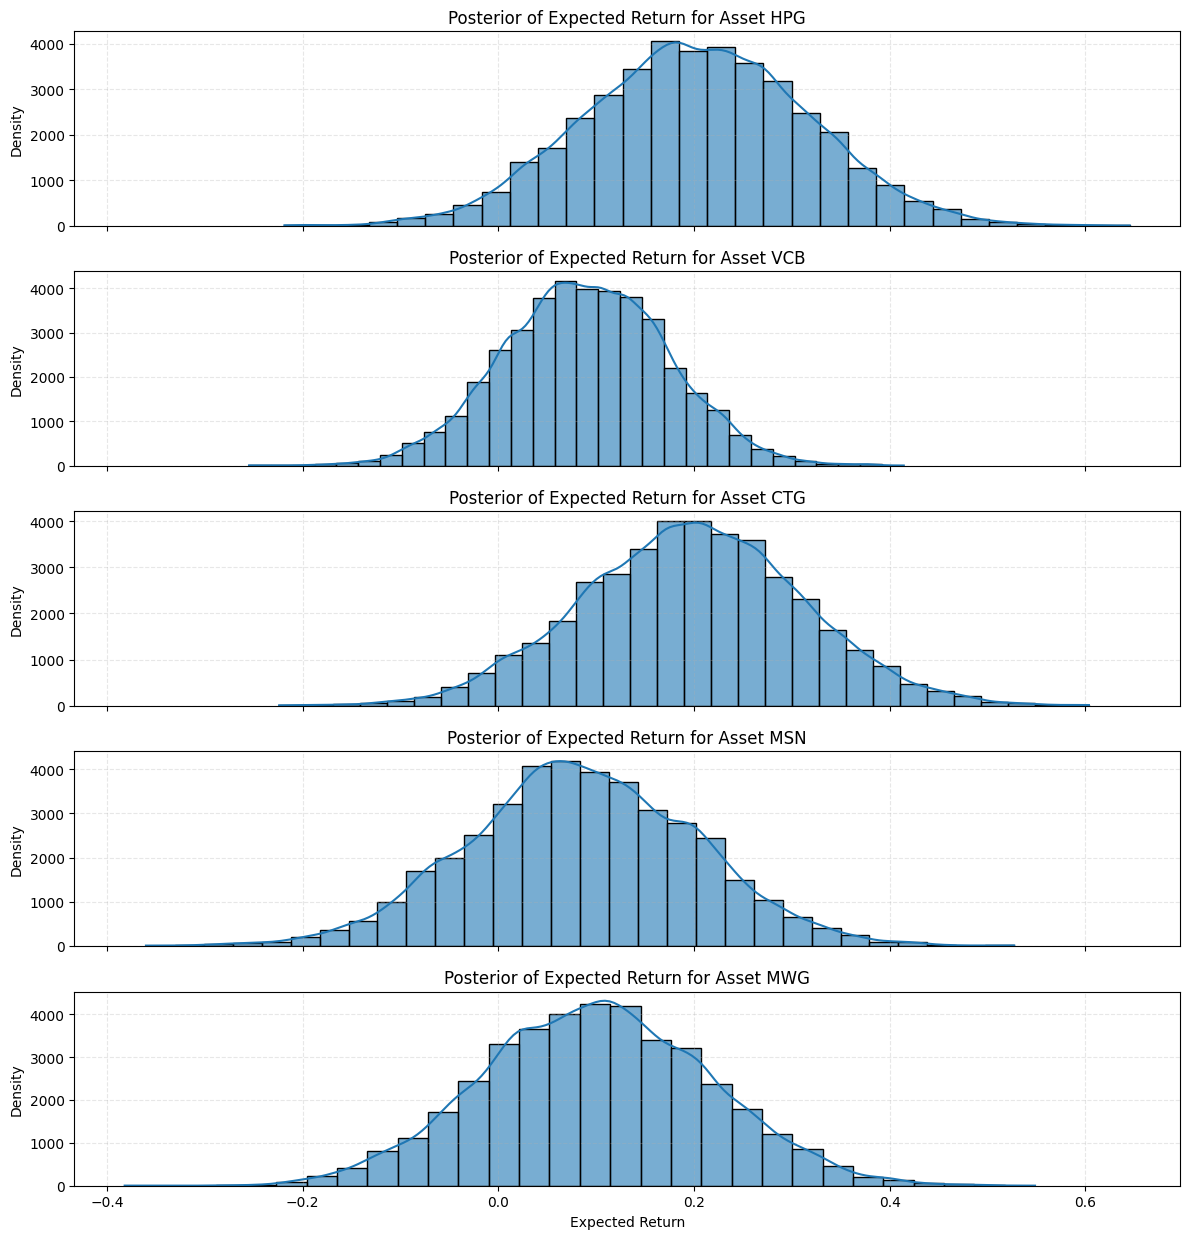

In [177]:
fig, axes = plt.subplots(n_assets, 1, figsize=(12, 2.5 * n_assets), sharex=True)

for i, name in enumerate(ASSETS):
    sns.histplot(mu_samples_flat[:, i], bins=30, kde=True, ax=axes[i], color="tab:blue", alpha=0.6)
    axes[i].set_title(f"Posterior of Expected Return for Asset {name}")
    axes[i].set_xlabel("Expected Return")
    axes[i].set_ylabel("Density")
    axes[i].grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

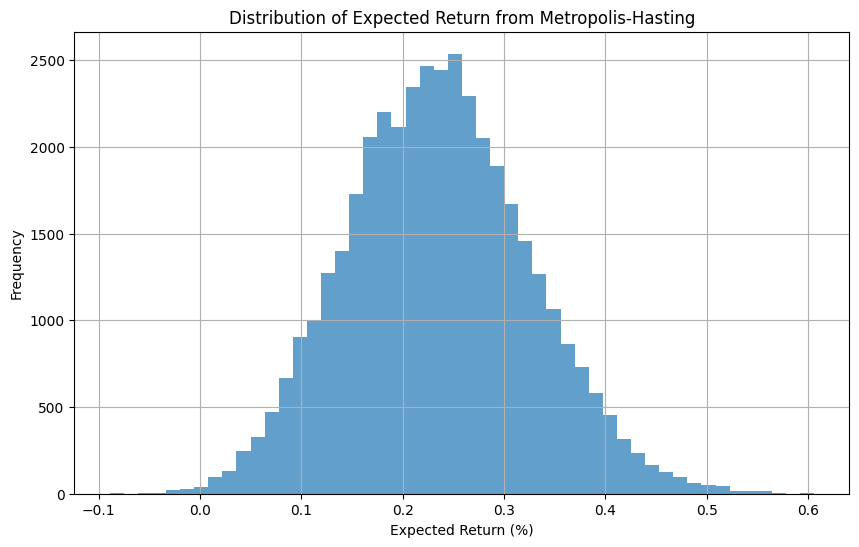

In [180]:
#Sharpe Ratio Distribution 
plt.figure(figsize=(10,6))
plt.hist(results["return"], bins=50, alpha=0.7, color="tab:blue")
plt.xlabel("Expected Return (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Expected Return from Metropolis-Hasting")
plt.grid(True)
plt.show()

## Result Variables

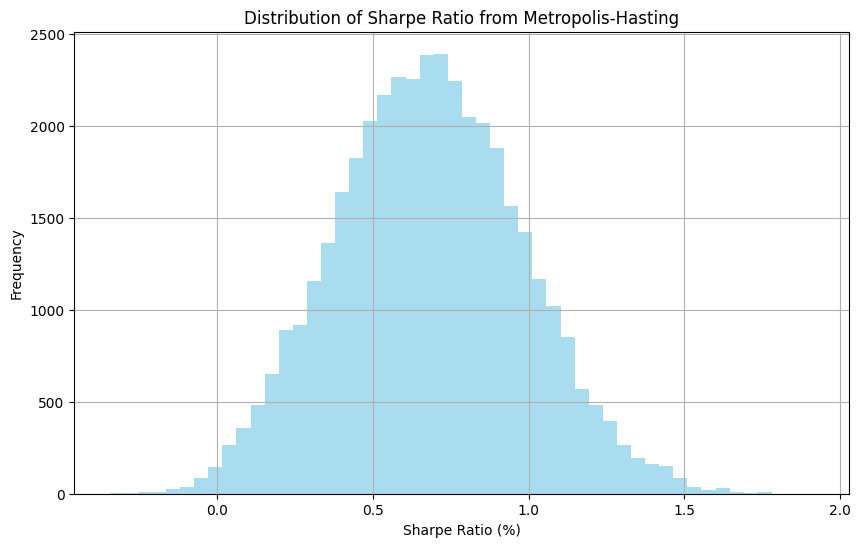


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                

In [170]:
#Sharpe Ratio Distribution 
plt.figure(figsize=(10,6))
plt.hist(results["sharpe"], bins=50, alpha=0.7, color="skyblue")
plt.xlabel("Sharpe Ratio (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Sharpe Ratio from Metropolis-Hasting")
plt.grid(True)
plt.show()

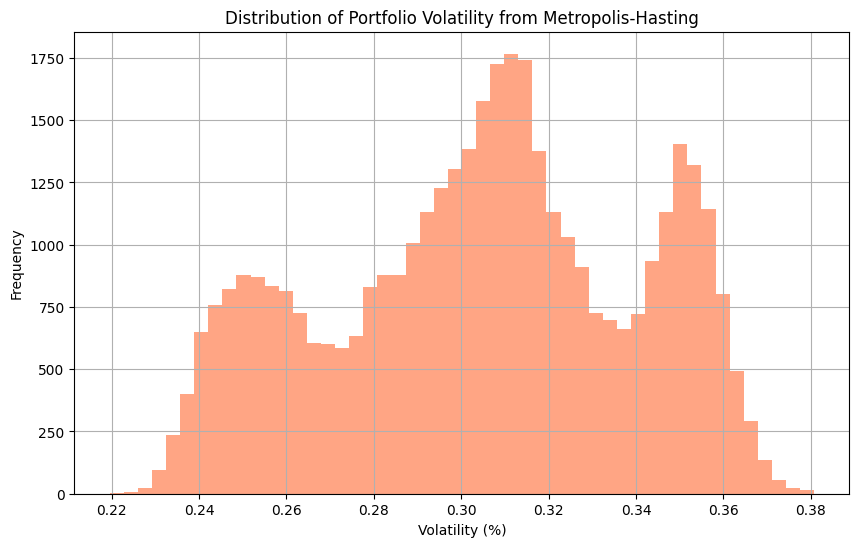


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                

In [182]:
#Volatility Distribution (std)
plt.figure(figsize=(10,6))
plt.hist(results["volatility"], bins=50, alpha=0.7, color="coral")
plt.xlabel("Volatility (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Portfolio Volatility from Metropolis-Hasting")
plt.grid(True)
plt.show()

CVaR EVALUATION FROM MH SAMPLES

Portfolio Statistics from MH samples:
Expected Return: 23.51% ± 9.01%
Mean Volatility: 30.46% ± 3.52%
Mean Sharpe:     0.681 ± 0.300

Risk Measures:
VaR (1%):  3.91%
CVaR (1%): 1.66%
VaR (5%):  9.07%
CVaR (5%): 5.98%


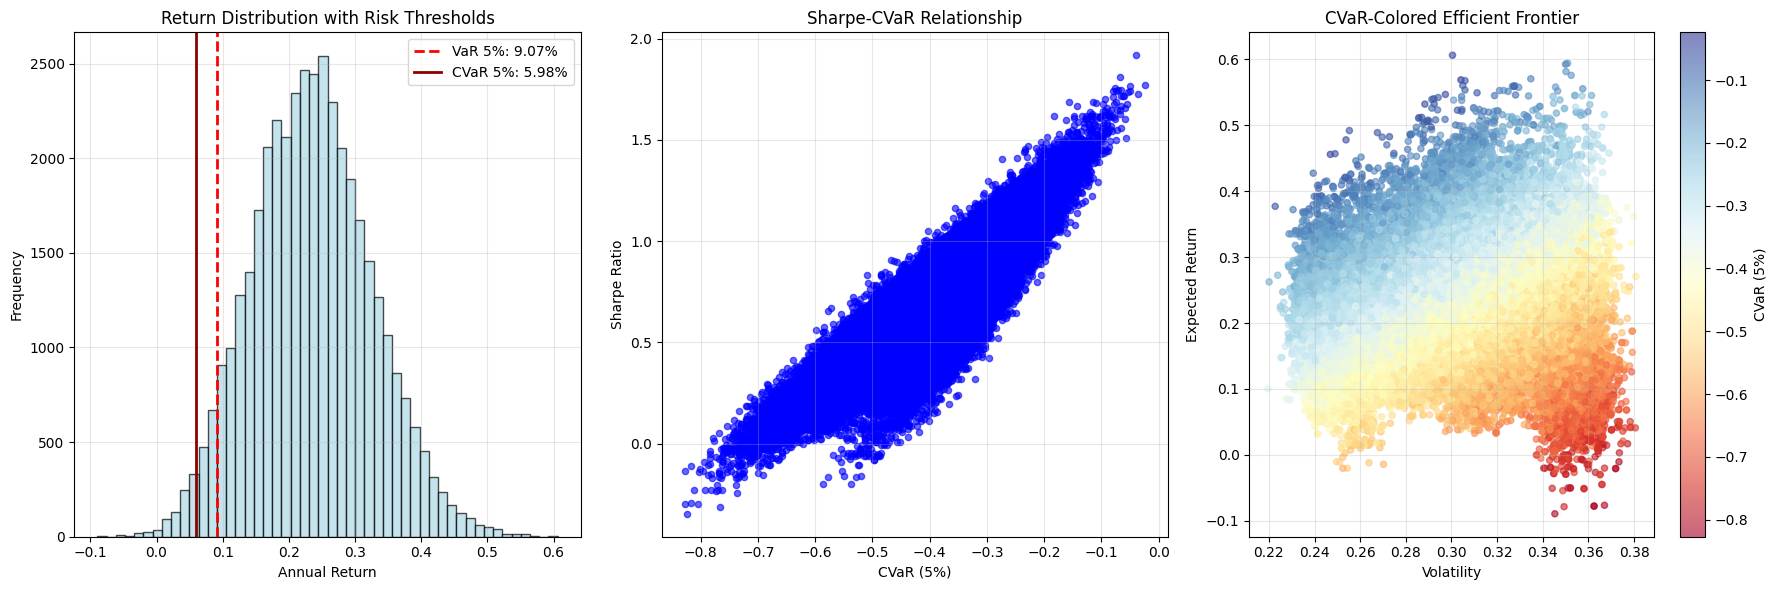

In [208]:
def calculate_var_cvar_from_distribution(returns, confidence_level=0.05):
    """
    Compute VaR and CVaR from the empirical distribution of returns.
    
    Parameters:
    -----------
    returns : array-like
        Array of portfolio returns obtained from MH sampling.
    confidence_level : float
        Confidence level (alpha), default is 0.05 (5%).
    
    Returns:
    --------
    tuple : (VaR, CVaR)
    """
    returns = np.array(returns)
    
    # VaR: Quantile at the specified confidence level
    var = np.percentile(returns, confidence_level * 100)
    
    # CVaR: Mean of all returns ≤ VaR
    tail_returns = returns[returns <= var]
    cvar = np.mean(tail_returns) if len(tail_returns) > 0 else var
    
    return var, cvar


# Compute CVaR for MH RESULTS

print("CVaR EVALUATION FROM MH SAMPLES")

# Returns extracted from MH results
returns_array = np.array(results["return"])
volatility_array = np.array(results["volatility"])
sharpe_array = np.array(results["sharpe"])
n_samples = len(returns_array)

print(f"\nPortfolio Statistics from MH samples:")
print(f"Expected Return: {np.mean(returns_array)*100:.2f}% ± {np.std(returns_array)*100:.2f}%")
print(f"Mean Volatility: {np.mean(volatility_array)*100:.2f}% ± {np.std(volatility_array)*100:.2f}%")
print(f"Mean Sharpe:     {np.mean(sharpe_array):.3f} ± {np.std(sharpe_array):.3f}")

# Compute empirical VaR/CVaR from the return distribution
confidence_levels = [0.01, 0.05]
print(f"\nRisk Measures:")

for cl in confidence_levels:
    var_emp, cvar_emp = calculate_var_cvar_from_distribution(returns_array, cl)
    print(f"VaR ({int(cl*100)}%):  {var_emp*100:.2f}%")
    print(f"CVaR ({int(cl*100)}%): {cvar_emp*100:.2f}%")

# VISUALIZATION
# Compute CVaR for each portfolio for color coding
individual_cvars = []
for i in range(len(returns_array)):
    # Assume each portfolio follows a normal distribution with its own mu and sigma
    portfolio_returns = np.random.normal(returns_array[i], volatility_array[i], 1000)
    _, cvar = calculate_var_cvar_from_distribution(portfolio_returns, 0.05)
    individual_cvars.append(cvar)

individual_cvars = np.array(individual_cvars)

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Return distribution with risk thresholds
var_5_emp, cvar_5_emp = calculate_var_cvar_from_distribution(returns_array, 0.05)

axes[0].hist(returns_array, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].axvline(var_5_emp, color='red', linestyle='--', linewidth=2, label=f'VaR 5%: {var_5_emp*100:.2f}%')
axes[0].axvline(cvar_5_emp, color='darkred', linestyle='-', linewidth=2, label=f'CVaR 5%: {cvar_5_emp*100:.2f}%')
axes[0].set_title('Return Distribution with Risk Thresholds')
axes[0].set_xlabel('Annual Return')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Sharpe-CVaR relationship
axes[1].scatter(individual_cvars, sharpe_array, alpha=0.6, s=20, color='blue')
axes[1].set_xlabel('CVaR (5%)')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Sharpe-CVaR Relationship')
axes[1].grid(True, alpha=0.3)

# 3. CVaR-colored efficient frontier
scatter = axes[2].scatter(volatility_array, returns_array, c=individual_cvars, alpha=0.6, s=20, cmap='RdYlBu')
axes[2].set_xlabel('Volatility')
axes[2].set_ylabel('Expected Return')
axes[2].set_title('CVaR-Colored Efficient Frontier')
plt.colorbar(scatter, ax=axes[2], label='CVaR (5%)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
